# Cosmological constraints for effective number of Dirac light neutrinos

<!-- See: https://doi.org/10.1371/journal.pcbi.1007007 Beginning that introduces the topic -->
If neutrinos are Dirac particles there will be extra light neutrinos in the primordial plasma. Here we show how to calculate the corresponding $\Delta N_{\text{eff}}$ when they theramilize through an extra gauge boson $Z'$

In [1]:
import numpy as py
from scipy.special import zeta
from scipy.optimize import bisect
from scipy import integrate as intg
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
%pylab inline
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

Populating the interactive namespace from numpy and matplotlib


## Standard Model relativistic degrees of freedom at a temperature $T$: $g(T)$ 

$g(T)$ is the number of relativistic degrees of freedom at a temperature $T$ in the SM. The decoupling temperature of the left-handed neutrinos $\nu_L$ is $ T^{\nu_{L}}_{\text{dec}} \approx 2.3 $ MeV, when $g(T^{\nu_{L}}_{ \text{dec}}) = 43/4 $ correspond to the three $\nu_{L}$, the $e^{\pm} $ and the photon. 

We obtain $g(T)$ function from simulated data in [arXiv:1807.06209](https://arxiv.org/abs/1807.06209). Fig 36.

In [2]:
Tdec_νL = 0.0023
T, g = np.loadtxt('GT.dat',usecols=(0,1),unpack=True); T*=1e-3
geff = InterpolatedUnivariateSpline(T, g)
g_eff = lambda T: geff(T)

Such that $g(3\ \text{MeV})~\sim 43/4$

In [3]:
print('43/4={0:.2f} ~ {1:.2f}'.format(43/4,g_eff(3E-3)) )

43/4=10.75 ~ 10.89


(2.10555908482e-05, 2611.95381537)

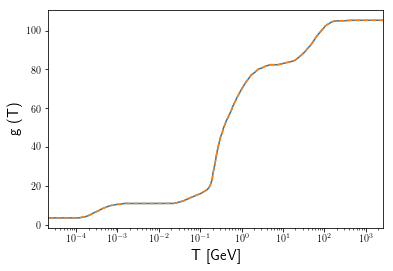

In [4]:
Tnew = np.logspace(np.log10(T[0]),np.log10(T[-1]),1000)
plt.plot(T,g,Tnew,g_eff(Tnew),'--')
plt.xscale('log')
plt.xlabel('T [GeV]',size=15)
plt.ylabel('g (T)',size=15)
plt.xlim(T[0],T[-1])

## $\Delta N_{\text{eff}}$ definition

<!-- Describe your steps: what you did and why you did it -->
In the case of our model, the new gauge symmetry introduces  new gauge boson that mediates interaction of the right neutrinos and the SM. This allows the right neutrinos to thermally modify the relativistic degrees of freedom with contributions given by

\begin{align*}
    \Delta N_{\text{eff}} = N_{\text{eff}} - N^{\text{SM}}_{\text{eff}} = N_{\nu_R} \left( \frac{T_{\nu_{R}}}{T_{\nu_{L}}} \right)^{4} = N_{\nu_R} \left( \frac{g(T^{\nu_{L}}_{\text{dec}})}{g(T^{\nu_{R}}_{\text{dec}})} \right)^{4/3}
\end{align*}

In [5]:
def ΔNeff1(Tdec_νL,Tdec_νR):
    return 1.0*(g_eff(Tdec_νL)/g_eff(Tdec_νR))**(4/3)

The Hubble expansion parameter is
\begin{align*}
    H(T) = \sqrt{\frac{8 \pi G_{N} \rho(T)}{3}} = \sqrt{\frac{4 \pi^{3} G_{N}}{45} \left( g(T) + \frac{21}{4} \right)} T^{2}\,,
\end{align*}
where $21/4$ correspond to the contribution of the right neutrinos to relativistic degrees of freedom.

In [6]:
def H(T, G_N):
    return np.sqrt(4.0*np.pi**3*G_N*(g_eff(T)+21.0/4.0)/45.0)*T**2

The interaction rate is given by
\begin{align*}
    \Gamma_{\nu_{R}}(T) = \frac{49 \pi^{5} T^{5}}{97200 \zeta(3)} \left( \frac{g^{\prime}}{M_{Z^{\prime}}} \right)^{4} \sum_{f} N^{C}_{f} Q^{2}_{f}\,,
\end{align*}

where the sum is performed over all SM fermion that are in thermal equilibrium with the plasma at temperature $T$: $\nu_{Li},e_L,e_R,\mu_L,\mu_R$, and with $N_c=3$ factor $u_L,u_R,d_L,d_R,s_L,s_R$

In [7]:
def ΓνR(T, g_νR, Q, gp, Mzp, par='B-L'):
            #[ uR,  uL, dL, dR,  eR,  eL, nu_L]
    if par == 'B-L':
        Qp = [1/3, 1/3, 1/3, 1/3, -1,  -1, -1  ] #B-L
    if par == 'B':
        Qp = [-1,    0,   0,   1,  1,   0,  0  ] #R
    if par == 'D':
        Qp = [1,   1/2, 1/2,   0, -2,-3/2, -3/2] #D
    if par == 'G':
        Qp = [-1/3,1/6, 1/6, 2/3,  0, -1/2, -1/2] #G
    Nc = [3, 3, 3, 3, 1, 1, 1]
    NF = [1, 1, 2, 2, 2, 2, 3]
    
    suma = 0
    for i in range(len(Nc)):
        suma += NF[i]*Nc[i]*(Qp[i])**2

    suma *= 1/2  #Dirac particles
    return (49/194400)*g_νR*Q**2*np.pi**5/zeta(3)*(gp/Mzp)**4*T**5*suma

## Thermalization condition

To estimate the contribution to the relativistic degrees of freedom for neutrinos, it is necessary to calculate the decoupling temperature of the right neutrinos ($T^{\nu_R}_{\text{dec}}$). The latter occurs when the interaction rate of neutrinos with the SM drop below the rate of expansion of the universe, i.e.

\begin{align*}
\Gamma(T^{\nu_R}_{\text{dec}}) = H(T^{\nu_R}_{\text{dec}})\,, 
\end{align*}

The next `bisect` function from `SciPy` found the roots a function (`ΓH`) between a given interval (`T[0],T[-1]`)

In [8]:
def TdecνR(Q,gp,Mzp,g_νR, G_N, par):
    ΓH = lambda T, g_νR, Q, gp, Mzp, G_N: ΓνR(T, g_νR, Q, gp, Mzp, par)-H(T, G_N)
    return bisect(ΓH,T[0],T[-1], args=(g_νR, Q, gp, Mzp, G_N))

By finding the decoupling temperature of the right neutrinos $T^{\nu_R}_{\text{dec}} $ with a root finding method, it is possible to calculate $\Delta N_{\text{eff}}$.

## $\Delta N_{\text{ eff}}$ calculation

In [9]:
def ΔNeff(Q, gp, Mzp, g_νR, G_N, par):
    ΔN = np.zeros(len(Mzp))
    for i in range(len(Mzp)-1):
        #print(i,Mzp[i])
        Tdec_νR = TdecνR(Q,gp,Mzp[i],g_νR, G_N, par)
        ΔN[i] = ΔNeff1(Tdec_νL,Tdec_νR)
    return ΔN

### General input

In [10]:
par = ['B-L','B','D','G']
Qp = [4, -5]
gp = 0.2
g_νR = 2
G_N = 6.70881e-39

### Benchmark point

Check for an $\operatorname{U}(1)_{B-L}$ point: Contribution to $\Delta N_{\text{ eff}}$ from a right handed neutrino of $X$-charge $-4$ with $M_{Z'}/g'=10\ \text{TeV}$

In [11]:
U1x=par[0]
qsvs=10000
MZp=qsvs*gp
i=0

In [12]:
TT = np.logspace(np.log10(T[0]),np.log10(T[-1]),10)

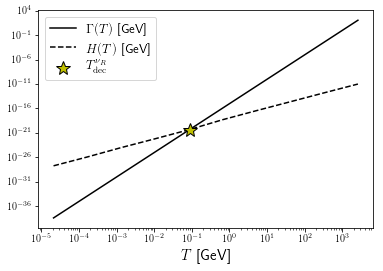

In [13]:
TdecνR4=TdecνR(Qp[i], gp, MZp, g_νR, G_N, U1x)
plt.plot(TT,ΓνR(TT,g_νR, Qp[i], gp, MZp,'B-L'),'k-',label=r'$\Gamma(T)$ [GeV]' )
plt.plot(TT,H(TT, G_N),'k--',label=r'$H(T)$ [GeV]' )
plt.plot(TdecνR4 ,H(TdecνR4, G_N),
         'y*', markersize=15,mec='k',label=r'$T^{\nu_R}_{\rm{dec}}$' )
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$T$ [GeV]',size=15)
plt.legend(loc='best',fontsize=13)
#plt.ylim(1E-5,10)

### General scan

Scan for each $X=B-L,R,D,G$: Contribution to $\Delta N_{\text{ eff}}$ from three right handed neutrino of $X$-charges $(-4,-4,+5)$ with 
$$4<\frac{M_{Z'}/g}{\text{TeV}}'< 101$$

In [14]:
Mzp = np.linspace(4000*gp,101000*gp,500)
ΔN_x = []
TνRdec_x = []

for U1x in par: #loop in models
    ΔN = []
    TνRdec = []
    for i in range(len(Qp)): # loop in right-handed neutrinos
        Tνdec = np.zeros(len(Mzp))
        for j in range(len(Mzp)):
            Tνdec[j] = TdecνR(Qp[i], gp, Mzp[j], g_νR, G_N, U1x)
        TνRdec.append(Tνdec)
        ΔN.append(ΔNeff(Qp[i], gp, Mzp, g_νR, G_N, U1x))
    TνRdec_x.append(2.0*TνRdec[0]+TνRdec[1])
    ΔN_x.append(2.0*ΔN[0]+ΔN[1])

The results of $T^{\nu_R}_{\text{dec}}$ and $\Delta N_{\text{eff}}$ as a function of $M_{Z^{\prime}}/g^{\prime}$ are exhibited in the next figure.

## Results

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


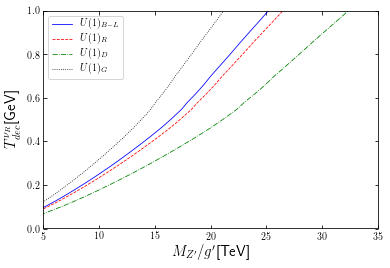

In [15]:
f = plt.figure()
plt.rc('text', usetex=True)

plt.plot(Mzp/gp*1e-3,TνRdec_x[0], 'b-', linewidth=0.8, label = r'$U(1)_{B-L}$')
plt.plot(Mzp/gp*1e-3,TνRdec_x[1], 'r--', linewidth=0.8, label = r'$U(1)_{R}$')
plt.plot(Mzp/gp*1e-3,TνRdec_x[2], 'g-.', linewidth=0.8, label = r'$U(1)_{D}$')
plt.plot(Mzp/gp*1e-3,TνRdec_x[3], 'k:', linewidth=0.8, label = r'$U(1)_{G}$')

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(5, 35)
plt.ylim(1e-3, 1)
#plt.grid(which='both')
plt.legend()
plt.xlabel(r'$M_{Z^{\prime}}/g^{\prime}$[TeV]',size=15)
plt.ylabel(r'$T^{\nu_{R}}_{dec}$[GeV]',size=15)

plt.tick_params(axis='both',direction='in',top='on',right='on')

f.savefig("T_dec.pdf", bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


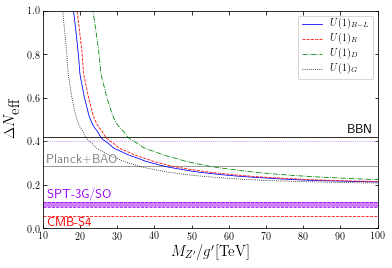

In [16]:
f = plt.figure()
plt.rc('text', usetex=True)
plt.axhspan(0.10, 0.12, facecolor='#9e02fd', alpha=0.5)
plt.axhline(y=0.285, color='#808080', linestyle='-', linewidth=0.8)
plt.axhline(y=0.058, color='#ff0000', linestyle='--', linewidth=0.8)
plt.axhline(y=0.12, color='#9e02fd', linestyle='--', linewidth=0.8)
plt.axhline(y=0.10, color='#9e02fd', linestyle='--', linewidth=0.8)
plt.axhline(y=0.4, color='#C264FF', linestyle=':', linewidth=0.8)
plt.axhline(y=0.42, color='k', linestyle='-', linewidth=0.8)

plt.plot(Mzp/gp*1e-3,ΔN_x[0], 'b-', linewidth=0.8, label = r'$U(1)_{B-L}$')
plt.plot(Mzp/gp*1e-3,ΔN_x[1], 'r--', linewidth=0.8, label = r'$U(1)_{R}$')
plt.plot(Mzp/gp*1e-3,ΔN_x[2], 'g-.', linewidth=0.8, label = r'$U(1)_{D}$')
plt.plot(Mzp/gp*1e-3,ΔN_x[3], 'k:', linewidth=0.8, label = r'$U(1)_{G}$')

plt.xlim(10,100)
plt.ylim(0,1)
plt.xlabel(r'$M_{Z^{\prime}}/g^{\prime} \textrm{[TeV]}$',size=15)
plt.ylabel(r'$\Delta N_{\textrm{eff}}$',size=15)
plt.legend(loc='upper right')

plt.text(92, .44, r'BBN', {'color': 'k', 'fontsize': 13})
plt.text(11, .3, r'Planck+BAO', {'color': '#808080', 'fontsize': 13})
plt.text(11, .14, r'SPT-3G/SO', {'color': '#9e02fd', 'fontsize': 13})
plt.text(11, .01, r'CMB-S4', {'color': '#ff0000', 'fontsize': 13})

plt.tick_params(axis='both',direction='in',top='on',right='on')

f.savefig("D_Neff.pdf", bbox_inches='tight')

We can see that for small decoupling temperatures, the variation in the number of relativistic degrees of freedom of the new species is large and vice versa. For our model we find that $M_{Z^{\prime}}/g^{\prime} \gtrsim 60$TeV in order to satisfy the conditions of $N_{eff}$ for all the symmetries studied here.

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


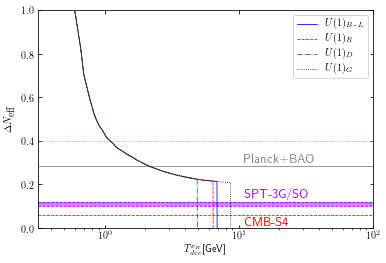

In [17]:
f = plt.figure()
plt.rc('text', usetex=True)
plt.axhspan(0.10, 0.12, facecolor='#9e02fd', alpha=0.5)
plt.axhline(y=0.285, color='#808080', linestyle='-', linewidth=0.8)
plt.axhline(y=0.058, color='#ff0000', linestyle='--', linewidth=0.8)
plt.axhline(y=0.12, color='#9e02fd', linestyle='--', linewidth=0.8)
plt.axhline(y=0.10, color='#9e02fd', linestyle='--', linewidth=0.8)
plt.axhline(y=0.4, color='#C264FF', linestyle=':', linewidth=0.8)

plt.plot(TνRdec_x[0],ΔN_x[0], 'b-', linewidth=0.8, label = r'$U(1)_{B-L}$')
plt.plot(TνRdec_x[1],ΔN_x[1], 'r--', linewidth=0.8, label = r'$U(1)_{R}$')
plt.plot(TνRdec_x[2],ΔN_x[2], 'g-.', linewidth=0.8, label = r'$U(1)_{D}$')
plt.plot(TνRdec_x[3],ΔN_x[3], 'k:', linewidth=0.8, label = r'$U(1)_{G}$')

plt.xlim(10**(-0.5),1e2)
plt.ylim(0,1)
plt.xlabel(r'$T^{\nu_{R}}_{dec}$[GeV]')
plt.ylabel(r'$\Delta N_{\textrm{eff}}$')
plt.legend(loc='upper right')
plt.xscale('log')

plt.text(11, .3, r'Planck+BAO', {'color': '#808080', 'fontsize': 13})
plt.text(11, .14, r'SPT-3G/SO', {'color': '#9e02fd', 'fontsize': 13})
plt.text(11, .01, r'CMB-S4', {'color': '#ff0000', 'fontsize': 13})

plt.tick_params(axis='both',direction='in',top='on',right='on')

f.savefig("Tdec_D_Neff.pdf", bbox_inches='tight')

# Appendix

[arXiv:1210.6350](https://arxiv.org/abs/1210.6350)

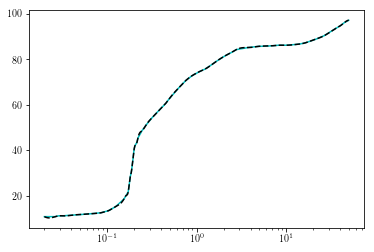

In [18]:
import pandas as pd
gT=pd.read_csv('gT.csv')

g_eff_c=InterpolatedUnivariateSpline(gT['T'], gT['g'])

Tnew = np.logspace(np.log10(gT['T'].values[0]),np.log10(gT['T'].values[-1]),1000)
plt.semilogx(gT['T'],gT['g'],'c-',label='Data')
plt.semilogx(Tnew,g_eff_c(Tnew),'k--',label='Data')
#plt.semilogx(Tnew,g_eff2(Tnew),'r--',label='Data')